# Imports

In [1]:
import requests, json
import torch
import torchvision
from torchvision.io import read_video
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn#, FasterRCNN_ResNet50_FPN_Weights
import itertools
import matplotlib.patches as patches


# Load Data JSON

In [2]:
backend = requests.get("https://backend.kaimerra.com/feed")
feed = backend.json()

In [3]:
#Download latest video, save to file
url = feed[45]['video_url']
r = requests.get(url, allow_redirects=True)
open('kaimerra_vid', 'wb').write(r.content)

1198528

In [4]:
#Load video as torch tensor
reader = torchvision.io.VideoReader('kaimerra_vid', "video")
output = []
#reader.seek(2)
for frame in reader:#itertools.takewhile(lambda x: x['pts'] <= 5, reader.seek(0)):
    output.append(frame['data'])

frames = torch.stack(output[0:5], dim=0)

In [5]:
reader.get_metadata()

{'video': {'duration': [10.216249999999999], 'fps': [7.416666666666667]},
 'audio': {'duration': [], 'framerate': []},
 'subtitles': {'duration': []},
 'cc': {'duration': []}}

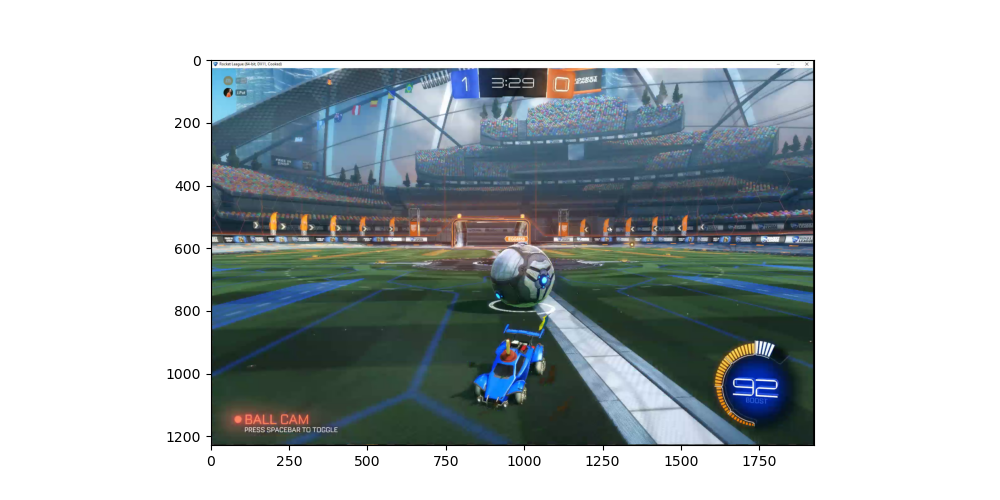

In [6]:
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

fig = plt.figure(figsize = (10,5))
ani_frames = [] # for storing the generated images
# fig, ax = plt.subplots(1,2)
for i in range(len(frames)):
    ani_frames.append([plt.imshow(frames[i].permute(1,2,0).numpy(), cmap=cm.Greys_r,animated=True)])
    

ani = animation.ArtistAnimation(fig, ani_frames, interval=30, blit=True,
                                repeat_delay=0)
# ani.save('movie.mp4')
plt.show()


In [7]:
from torchvision.transforms.functional import convert_image_dtype


model = fasterrcnn_resnet50_fpn(pretrained = True, progress=False)
# model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained = True, progress=False)
# model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained = True, progress=False)

imgs = convert_image_dtype(frames,dtype=torch.float)

model = model.eval()

CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

outputs = model(imgs)#frames.float()/255)

/home/alec/anaconda3/envs/Kaimerra/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
outputs[4]['scores']

tensor([0.8975, 0.5461, 0.5018, 0.4506, 0.4261, 0.3246, 0.3185, 0.2976, 0.2884,
        0.2717, 0.2647, 0.2303, 0.2206, 0.2167, 0.1820, 0.1816, 0.1806, 0.1515,
        0.1398, 0.1335, 0.1312, 0.1299, 0.1205, 0.1177, 0.1173, 0.1108, 0.1058,
        0.0950, 0.0911, 0.0824, 0.0824, 0.0798, 0.0762, 0.0746, 0.0740, 0.0737,
        0.0681, 0.0669, 0.0651, 0.0625, 0.0608, 0.0607, 0.0604, 0.0576, 0.0572,
        0.0561, 0.0558, 0.0556, 0.0545, 0.0523, 0.0512, 0.0511, 0.0509],
       grad_fn=<IndexBackward0>)

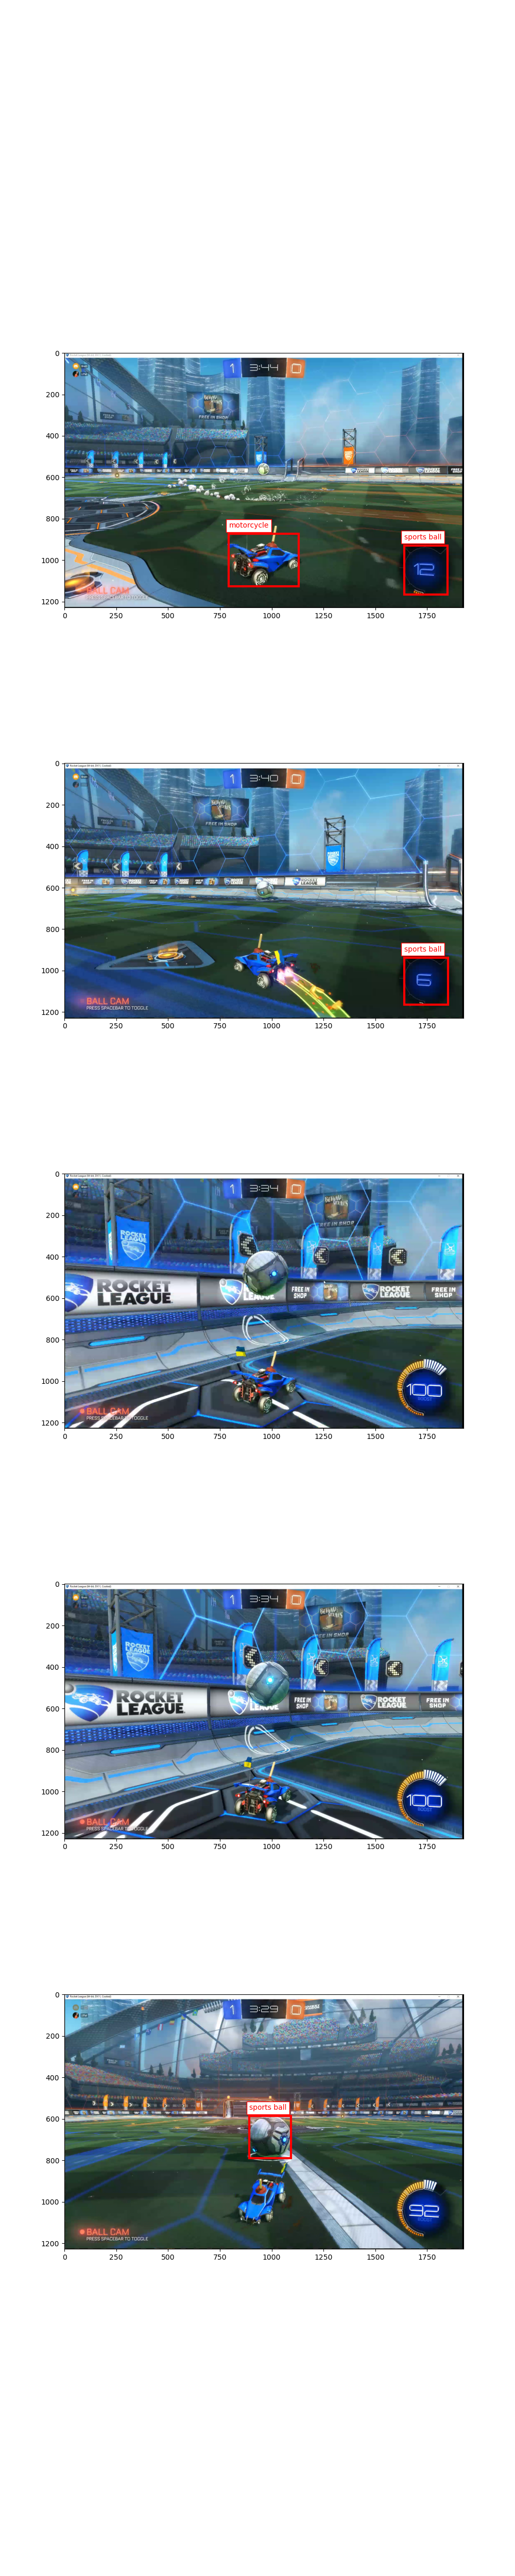

In [18]:
score_threshold = 0.8

label_idxs = [[label for label in output['labels'][(output['scores'] > score_threshold).nonzero()]]for output in outputs]
labels = [[CATEGORY_NAMES[idx] for idx in label_idx] for label_idx in label_idxs]
boxes = [[box[0] for box in output['boxes'][(output['scores'] > score_threshold).nonzero()]]for output in outputs]

# score_indices = np.arange(0,5) #The scores are listed in order, so the 0th score was the top scoring bounding box
# label_idxs = [[output['labels'][score_idx] for output in outputs] for score_idx in score_indices]
# labels = [[CATEGORY_NAMES[idx] for idx in label_idx] for label_idx in label_idxs]
# boxes = [[output['boxes'][score_idx] for output in outputs] for score_idx in score_indices]

def get_box(box):
    xy = box[0:2]
    width = box[2] - box[0]
    height = box[3] - box[1]
    return xy.detach().numpy(), width.detach().numpy(), height.detach().numpy()
    
fig, ax = plt.subplots(len(outputs),figsize = (10,10 * len(outputs)))
for frame_idx,frame in enumerate(frames):
    ax[frame_idx].imshow(frame.permute(1,2,0))
    
    for box_idx,box in enumerate(boxes[frame_idx]):
        xy, width, height = get_box(box)
        rectangle = patches.Rectangle(xy = xy,
                                      width = width,
                                      height = height,
                                      linewidth=3, edgecolor='r', facecolor='none')
        ax[frame_idx].add_patch(rectangle)
        # ax[idx].set_title(labels[idx])
        ax[frame_idx].text(xy[0], xy[1]-30, labels[frame_idx][box_idx], color='red', 
        bbox=dict(facecolor='white', edgecolor='red'))